# **Redes Neuronales Artificiales**
# Proyecto Final - Sistema de reconocimiento de rostros
<img style="float: right; padding-right: 10px;" height="220" src="https://drive.google.com/uc?id=0BzGoTc_BVojJUGJvMWRQVVllV0U"> <br>**Universidad del Valle** <br>
**Escuela de Ingeniería Eléctrica y Electrónica** <br>
**Área de Informática Industrial** <br>

**Profesores:** Wilfredo Alfonso Morales y Eduardo Caicedo <br>
**Estudiante:** Juan José López Flórez - 1730514 <br>
**Enlace DRIVE:** https://drive.google.com/drive/folders/1ySWeVSEeypbw_R2AgCqBcvRvra8gP5E4?usp=sharing<br> 

# Introducción
---

La idea de identificar a las personas por sus rasgos faciales se remonta a la década  de los años 60. En esta época, el matemático e informático Woodrow Bledsoe hizo el primer experimento de identificación con una tableta RAND (antecesor de las tabletas táctiles modernas) que permitía identificar manualmente características biométricas. El experimento tuvo poco éxito por las limitaciones de la época, pero presentó el primer antecedente de reconocimiento de rostros.

En la actualidad, el reconocimiento facial es uno de los temas más investigado, debido a su potencial en aplicaciones prácticas como: control de acceso en smartphones, sistemas  de seguridad, agilizar procesos bancarios, identificación de pacientes para evitar errores en formulaciones médicas y localización de personas desaparecidas. Además, su auge se debe también a los avances tecnológicos en hardware y software, a las metodologías de identificación de personas a partir de sus rasgos biométricos y además, a la automatización de los sistemas de reconocimiento, eliminando la necesidad de intervención de algún operario.


# Problemática
---
Implementar un sistema de reconocimiento de rostros en imágenes digitales. 
Se utiliza la base de datos: "2D face sets de Ian Craw at Abeerden". La base de datos cuenta con 687 imágenes a color, repartidas entre 1 y 18 imágenes de noventa personas. Además, las imágenes cuentan con algunas variaciones en iluminación y diferentes posiciones del rostro. El tamaño de las imágenes varia entre 336x480 a 624x544 píxeles.

# Solución Propuesta
---
Se propone un sistema de reconocimiento de rostros que combina las técnicas: MTCNN + FaceNet + SVM. La primera para detección de rostros, la segunda para extracción de características y la última para clasificación.



### 1. Configuración del drive e importación de librerias

In [182]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Universidad - Ingeniería Electrónica/9 Semestre/Redes Neuronales (2022)/Proyecto Final/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [183]:
# Se instala la libreria MTCNN
!pip install mtcnn

In [224]:
import os
import shutil
import numpy 
from PIL import Image 
from os import listdir
from numpy import savez_compressed
from numpy import asarray
from numpy import expand_dims
from numpy import load
from random import choice
from matplotlib import pyplot as plt
#from numpy import reshape

from mtcnn.mtcnn import MTCNN
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model 
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

## 2. Preparación de datos utilizando el detector de rostros MTCNN

- La MTCNN es una técnica de aprendizaje profundo que consiste en tres etapas de redes convolucionales en cascada (P-Net, R-Net y O-Net) que predicen la ubicación de rostros y puntos de referencia en una imagen tanto fija como en tiempo real.

- Inicialmente, dada una imagen de entrada se redimensiona a diferentes escalas para construir una imagen piramidal, esta es la entrada de las tres etapas de la red MTCNN. En la primera etapa, se producen ventanas candidatas a través de una red de propuesta rápida (P-Net). Luego, se refinan las ventanas candidatas para rechazar una gran cantidad de ventanas sin rostros a través de una red de refinamiento (R-Net). Finalmente, la red de salida (O-Net) sirve para refinar el resultado, producir el cuadro delimitador final y generar cinco posiciones de puntos de referencia faciales 

- Esta implementación recibe una imagen de entrada de tamaño entre 336x480 a 624x544 píxeles, y después de detectar el rostro y recortar se obtiene una imagen con tamaño de 160x160 píxeles.

- Para esta implementación se utiliza la librería MTCNN.

In [ ]:
# Función para extraer las imágenes
def extract_image(image):
  img = Image.open(image)            
  img = img.convert('RGB')          
  pixels = asarray(img)  # Conversión a un arreglo
  detector = MTCNN() #Creación del detector MTCNN
  result = detector.detect_faces(pixels)
  x1, y1, w, h = result[0]['box'] #Extración del cuadro delimitador del primer rostro         
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = abs(x1 + w), abs(y1 + h)
  face = pixels[y1:y2,x1:x2] #Extración del rostro
  img = Image.fromarray(face,'RGB')  
  img = img.resize((160,160))  
  face_array = asarray(img)  
  return face_array

# Función para obtener los rostros
def load_faces(directory):
  faces = []
  for filename in listdir(directory):
    path = directory + filename
    face = extract_image(path)
    faces.append(face)
  return faces

# Función para obtener datos faciales y sus etiquetas 
def load_dataset(directory):
  x, y = [],[]
  for subdir in listdir(directory):
    path = directory + subdir + '/'
    faces = load_faces(path) #Cargar todas los rostros de la ruta
    labels = [subdir for _ in range(len(faces))] #Creación de etiquetas
    x.extend(faces)
    y.extend(labels)
  return asarray(x), asarray(y)  

In [ ]:
#Cargar datos de entrenamiento
trainX,trainY = load_dataset(path + 'dataset/train/')
print('Cargando dataset train:')
print('Hay %d imágenes' %trainX.shape[0])  
print('Tamaño de imágenes: %d x %d pixeles' %(trainX.shape[1], trainX.shape[2]))

#Cargar datos de test
testX, testY = load_dataset(path + 'dataset/test/')
print('Cargando dataset test:')
print('Hay %d imágenes' %testX.shape[0])  
print('Tamaño de imágenes: %d x %d pixeles' %(testX.shape[1], testX.shape[2]))

#Guardar datos en un archivo en formato comprimido 
savez_compressed('faces-dataset.npz', trainX, trainY, testX, testY)
shutil.copy('faces-dataset.npz', path) 

Cargando dataset train:
Hay 466 imágenes
Tamaño de imágenes: 160 x 160 pixeles
Cargando dataset test:
Hay 221 imágenes
Tamaño de imágenes: 160 x 160 pixeles


'/content/drive/MyDrive/Universidad - Ingeniería Electrónica/9 Semestre/Redes Neuronales (2022)/Proyecto Final/faces-dataset.npz'

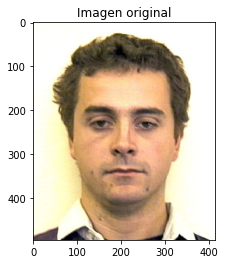

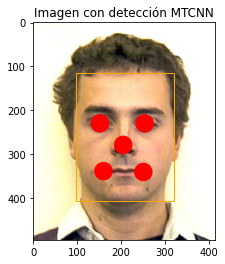

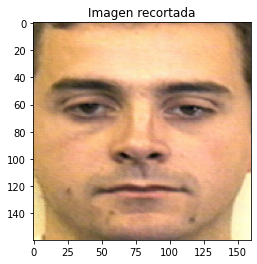

In [ ]:
#Función para dibujar la imagen con el rostro detectado
def draw_facebox(filename, result_list):
  data = plt.imread(filename) 
  plt.imshow(data) 
  ax = plt.gca() #Obtener el contexto para dibujar las cajas
  for result in result_list: 
    x, y, width, height = result['box'] #Obtener coordenadas
    rect = plt.Rectangle((x, y), width, height,fill=False, color='orange') #Creación de la forma rectangulo
    ax.add_patch(rect) #Dibujar la caja
  for key, value in result['keypoints'].items(): 
    dot = plt.Circle(value, radius=20, color='red') #Creación de las forma de puntos
    ax.add_patch(dot) #Dibujar puntos característicos

  title = 'Imagen con detección MTCNN'
  plt.title(title)
  plt.show() 

# Ejemplo del funcionamiento del detector MTCNN 
filename = path + 'dataset/test/Amellanby/amellanby5.jpg' 
pixels = plt.imread(filename) 
detector = MTCNN()
faces = detector.detect_faces(pixels)

x1, y1, w, h = faces[0]['box'] #Extración del cuadro delimitador del primer rostro         
x1, y1 = abs(x1), abs(y1)
x2, y2 = abs(x1 + w), abs(y1 + h)
face = pixels[y1:y2,x1:x2] #Extración del rostro
img = Image.fromarray(face,'RGB')  
img = img.resize((160,160))

#Plot
plt.imshow(pixels)
title = 'Imagen original'
plt.title(title)
plt.show()

draw_facebox(filename, faces) 

#Plot
plt.imshow(img)
title = 'Imagen recortada'
plt.title(title)
plt.show()

## 3. Extracción de características con FaceNet

- FaceNet es un sistema de reconocimiento facial diseñado por Google, que a partir de una imagen de entrada con un rostro, extrae características de alta calidad de la cara y predice una representación vectorial de 128 elementos de estas características, llamada incrustación de cara. Para lograr esto, FaceNet realiza un mapeo de las imágenes a un espacio euclidiano compacto donde las distancias corresponden directamente a una medida de similitud de rostros.

- Se pueden implementar dos tipos de arquitecturas. La primera arquitectura se basa en el modelo de Zeiler & Fergus, y la segunda arquitectura se basa en el modelo Inception.  

- Inception es un modelo de reconocimiento de imágenes muy utilizado, que se ha desarrollado durante años, por lo que tiene actualmente cuatro versiones. Su primera arquitectura fue dada por nueve miembros, donde siete eran de Google, uno de la Universidad de Carolina del Norte y otro de la Universidad de Michigan.

- El modelo Inception se compone de diferentes bloques, entre los cuales hay: convoluciones, reducciones promedio, agrupaciones máximas, concatenaciones, abandonos y capas completamente conectadas.

- La red FaceNet es entrenada a través de una función llamada Triplet Loss. La función Triplet Loss busca que los vectores de la misma identidad se vuelvan más similares (menor distancia), mientras que se espera que los vectores de diferentes identidades se vuelvan menos similares (mayor distancia). 

- Esta implementación recibe como entrada datos de entrada con tamaño de (?, 160, 160, 3) y después de extraer las caracteristicas, reduce las dimensiones a (?, 128). Es decir, obtiene 128 incrustaciones vectoriales como extractor de características.

- Para esta implementación se utiliza el modelo FaceNet disponible en Kaggle que utiliza la red Inception-ResNet-V1.

In [ ]:
#Función para generalizar los datos y extraer las incrustaciones
def extract_embeddings(model, face_pixels):
  face_pixels = face_pixels.astype('float32')  
  mean, std = face_pixels.mean(), face_pixels.std() #Evaluación de la media y desviación estándar de los datos 
  face_pixels = (face_pixels - mean)/std       
  samples = expand_dims(face_pixels,axis=0)  
  yhat = model.predict(samples)
  return yhat[0]

#Carga del conjunto de datos comprimido y el modelo de facenet keras 
print('Cargando datos de entrenamiento y test:')
data = load(path + 'faces-dataset.npz')
trainX, trainY, testX, testY = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Tamaño de data train:', trainX.shape)
print('Tamaño de data test:', testX.shape)

facenet_model = load_model(path + 'models/facenet_keras.h5') #Carga del modelo FaceNet
print('Incrustando datos de entrenamiento y test:')
#Conversión de los rostros de entrenamiento a una incrustación 
new_trainX = list()
for face_pixels in trainX:
  embedding = extract_embeddings(facenet_model, face_pixels)
  new_trainX.append(embedding)
new_trainX = asarray(new_trainX)             
print('Nuevo tamaño de data train:', new_trainX.shape)

#Conversión de los rostros de test a una incrustación
new_testX = list()
for face_pixels in testX:
	embedding = extract_embeddings(facenet_model, face_pixels)
	new_testX.append(embedding)
new_testX = asarray(new_testX)
print('Nuevo tamaño de data test:', new_testX.shape)

#Guardar datos en un archivo en formato comprimido 
savez_compressed('faces-embeddings.npz', new_trainX, trainY, new_testX, testY)
shutil.copy('faces-embeddings.npz', path) 

Cargando datos de entrenamiento y test:
Tamaño de data train: (466, 160, 160, 3)
Tamaño de data test: (221, 160, 160, 3)
Incrustando datos de entrenamiento y test:
Nuevo tamaño de data train: (466, 128)
Nuevo tamaño de data test: (221, 128)


'/content/drive/MyDrive/Universidad - Ingeniería Electrónica/9 Semestre/Redes Neuronales (2022)/Proyecto Final/faces-embeddings.npz'

### Anexo: pruebas FaceNet

Se intentó entrenar el modelo FaceNet con el fin de realizar pruebas de sensibilidad a hiper-parámetros, sin embargo, no se pudo lograr avances significativos. 
Queda como actividad futura a realizar con motivos de aprendizaje.

In [238]:
facenet_model = load_model(path + 'models/facenet_keras.h5') #Carga del modelo FaceNet
facenet_model.load_weights(path + 'models/weights.h5')
facenet_model.summary() # Construcción del modelo

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

In [261]:
#facenet_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
#facenet_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
facenet_model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

In [262]:
print('Cargando datos de entrenamiento y test')
data = load(path + 'faces-dataset.npz')
trainX, trainY, testX, testY = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Tamaño de data train:', trainX.shape)
print('Tamaño de data test:', testX.shape)

Cargando datos de entrenamiento y test
Tamaño de data train: (466, 160, 160, 3)
Tamaño de data test: (221, 160, 160, 3)


In [263]:
diccionario = {'Adrian': 1, 'Alec': 2, 'Alison': 3, 'Alister': 4, 'Amellanby': 5, 'Andrew': 6, 'Annanena': 7, 'Anon': 8, 'Barry': 9, 'Bfegan': 10, 'Blair': 11, 'Blaw': 12, 'Brian': 13, 
               'Caroline': 14, 'Catherine': 15, 'Chris_Harbron': 16, 'Chris_Pin': 17, 'Chris': 18, 'Dave': 19, 'David_Imray': 20, 'David': 21, 'Dbell': 22, 'Derek': 23, 'Dhands': 24, 
               'Dhawley': 25, 'Dlow': 26, 'Dougal': 27, 'Dpearson': 28, 'Dsmith': 29, 'Fiona_Hogart': 30, 'Fiona': 31, 'George': 32, 'Gfindley': 33, 'Ghall': 34, 'Gillian': 35, 'Gordon': 36,
               'Graeme': 37, 'Graham': 38, 'Grant': 39, 'Hack': 40, 'Heather': 41, 'Hin': 42, 'Ian': 43, 'Irene': 44, 'Iroy': 45, 'Itaylor': 46, 'Jenni': 47, 'Jim': 48, 'Joanna': 49, 'Johannes': 50,
               'John_Mccal': 51, 'John_Thom': 52, 'Johnny': 53, 'Jsheenan': 54, 'Kay': 55, 'Kieran': 56, 'Kim': 57, 'Kirsty': 58, 'Lisa': 59, 'Louise': 60, 'Lynn_James': 61, 'Lynn': 62, 'Marie': 63, 
               'Mark': 64, 'Martin': 65, 'Meggan': 66, 'Merilyn': 67, 'Michael': 68, 'Milly': 69, 'Miranda': 70, 'Mmanson': 71, 'Mnicholson': 72, 'Neil': 73, 'Nick': 74, 'Olive': 75, 'Paol': 76,
               'Pat': 77, 'Paul': 78, 'Peter_Macgeorge': 79, 'Peter': 80, 'Pkyle': 81, 'Richard': 82, 'Ruth': 83, 'Scott': 84, 'Simon': 85, 'Stephen': 86, 'Stewart': 87, 'Terry': 88, 'Tock': 89, 
               'Tracy': 90, 'Trevor': 91}

In [264]:
new_trainY = []
new_testY = []

for item in trainY:
  for key in diccionario:
    if key == item:
      value = diccionario[key]
      new_trainY.append(value)
    else:
      continue

for item in testY:
  for key in diccionario:
    if key == item:
      value = diccionario[key]
      new_testY.append(value)
    else:
      continue


In [265]:
print(new_trainY)
print(new_testY)

[1, 1, 1, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 11, 12, 12, 12, 13, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 17, 18, 18, 18, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 30, 31, 32, 33, 33, 33, 34, 34, 34, 35, 36, 36, 36, 37, 37, 37, 37, 37, 38, 39, 40, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 50, 51, 52, 53, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 

In [266]:
new_trainY = numpy.array(new_trainY)
new_testY = numpy.array(new_testY)

In [267]:
result = facenet_model.fit(trainX, new_trainY, epochs=30, batch_size=20, shuffle=True, validation_data=(testX, new_testY))
#result = facenet_model.fit(trainX, new_trainY, epochs=30, batch_size=20)

Epoch 1/30
24/24 [==============================] - 160s 5s/step - loss: 3320.8828 - accuracy: 0.0043 - val_loss: 1048.8993 - val_accuracy: 0.0045
Epoch 2/30
24/24 [==============================] - 140s 6s/step - loss: 3300.7942 - accuracy: 0.0086 - val_loss: 2232.9124 - val_accuracy: 0.0000e+00
Epoch 3/30
24/24 [==============================] - 127s 5s/step - loss: 3296.5615 - accuracy: 0.0064 - val_loss: 2946.4109 - val_accuracy: 0.0362
Epoch 4/30
24/24 [==============================] - 122s 5s/step - loss: 3290.4407 - accuracy: 0.0064 - val_loss: 3047.5496 - val_accuracy: 0.0136
Epoch 5/30
24/24 [==============================] - 123s 5s/step - loss: 3287.8035 - accuracy: 0.0043 - val_loss: 3104.4512 - val_accuracy: 0.0000e+00
Epoch 6/30
24/24 [==============================] - 123s 5s/step - loss: 3285.4827 - accuracy: 0.0043 - val_loss: 3111.0623 - val_accuracy: 0.0000e+00
Epoch 7/30
24/24 [==============================] - 122s 5s/step - loss: 3281.6545 - accuracy: 0.0043 - va

In [269]:
#decoded_imgs = full_autoencoder_t1.predict(x_test)
facenet_model.save(path + 'facenet_model.h5')

In [271]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []

train_loss, train_acc = facenet_model.evaluate(trainX, new_trainY)
test_loss, test_acc = facenet_model.evaluate(testX, new_testY)

train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

7/7 [==============================] - 10s 1s/step - loss: 3114.8201 - accuracy: 0.0000e+00


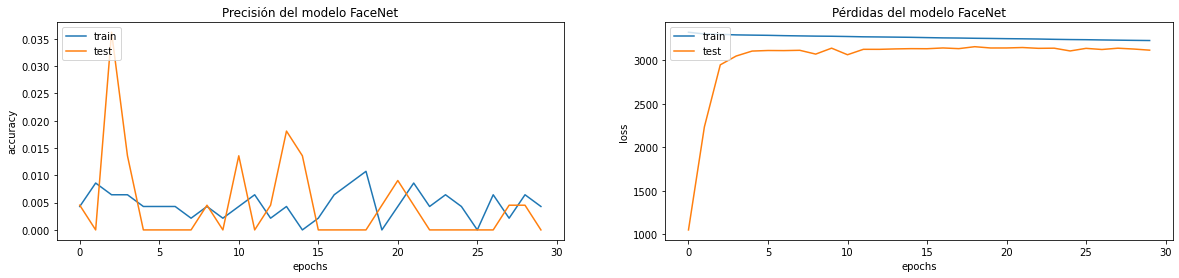

In [273]:
# Imprimir los datos de topología FaceNeT

# Accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('Precisión del modelo FaceNet')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

#Loss
plt.subplot(1,2,2)
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Pérdidas del modelo FaceNet')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 4. Clasificación de rostros con SVM

- El método de clasificación-regresión Máquinas de Vector Soporte (Vector Support Machines, SVMs) fue desarrollado en la década de los 90, dentro de campo de la ciencia computacional. Si bien originariamente se desarrolló como un método de clasificación binaria, su aplicación se ha extendido a problemas de clasificación múltiple y regresión. SVMs ha resultado ser uno de los mejores clasificadores para un amplio abanico de situaciones, por lo que se considera uno de los referentes dentro del ámbito de aprendizaje estadístico y machine learning.

- Las Máquinas de Vector Soporte se fundamentan en el Maximal Margin Classifier, que a su vez, se basa en el concepto de hiperplano. 

- Las SVM (Support vector machine) crea un hiperplano óptimo para clasificar las clases del conjunto de datos de entrenamiento en función de las diferentes características del rostro. La dimensionalidad del hiperplano es uno menos que el número de características. Se pueden aplicar diferentes kernels para ver qué características utiliza el clasificador para eliminar las características si es necesario. Esto puede ayudar a mejorar la velocidad.

- Se implementa la SVM con ayuda de la librería sklearn.

In [ ]:
#Cargar rostros
data = load(path + 'faces-dataset.npz')
testX = data['arr_2']

#Cargar rostros incrustados
data = load(path + 'faces-embeddings.npz')
new_trainX, trainY, new_testX, testY = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

#Normalización vectores de entrada
in_encoder = Normalizer(norm='l2')
new_trainX = in_encoder.transform(new_trainX)
new_testX = in_encoder.transform(new_testX)

#Etiquetas para clasificación
out_encoder = LabelEncoder()
out_encoder.fit(trainY)
trainY = out_encoder.transform(trainY)
testY = out_encoder.transform(testY)

#Entrenamiento del modelo SVM
model = SVC(kernel='linear', probability=True)
model.fit(new_trainX, trainY)

SVC(kernel='linear', probability=True)

Predicción: Tock (20.246)
Esperado: Tock


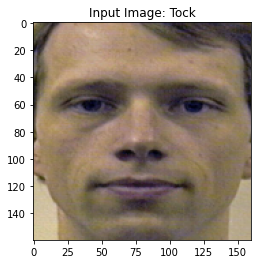

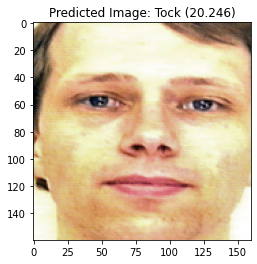

In [ ]:
#Prueba del modelo con un ejemplo aleatorio del dataset test.
selection = choice([i for i in range(new_testX.shape[0])])
random_face_pixels = testX[selection]
random_face_emb = new_testX[selection]
random_face_class = testY[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

#Predicción para el rostro
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

#Obtención del nombre
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
list_trainY = list(trainY)
p = class_index
if p in list_trainY:
  val = list_trainY.index(p)

print('Predicción: %s (%.3f)' % (predict_names[0], class_probability))
print('Esperado: %s' % random_face_name[0])


#Plot Input Image
plt.imshow(random_face_pixels)
#title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title('Input Image: %s' % random_face_name[0])
plt.show()

#Plot Predict Image
plt.imshow(trainX[val])
plt.title('Predicted Image: %s (%.3f)' % (predict_names[0], class_probability))
plt.show()

# Conclusiones
---
*   La red MTCNN presenta muy buenos resultados en la detección de rostros y puntos claves. Esto valida la documentación encontrada en relación a la buena reputación que tiene la técnica en aplicaciones de reconocimiento facial.
*   Se concluye que la unión de CNNs permite obtener una red más robusta para diferentes aplicaciones. Por ejemplo, en la detección de rostros, con la MTCNN, se observa que las tres CNNs (P-Net, R-Net, O-Net) hacen que la red detecte y alinee de manera más acertada la imagen de entrada.
*   Se resalta el trabajo que realiza FaceNet en extracción de características, logrando reducir dimensiones hasta 128 incrustaciones vectoriales. Teniendo en cuenta que como entrada recibe imágenes con (160,160,3).





# Referencias
---


[1] Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks. K. Zhang, Z. Zhang, Z. Li, Y. Qiao. 2016

[2] FaceNet: A Unified Embedding for Face Recognition and Clustering. F. Schroff, D. Kalenichenko. J. Philbin, 2015

[3] 2D face sets,  Ian Craw at Abeerden. Disponible en: http://pics.psych.stir.ac.uk/2D_face_sets.htm

[4] ¿Cómo crear un modelo de reconocimiento facial usando FaceNet Keras?, ICHI.PRO. Disponible en: https://ichi.pro/es/como-crear-un-modelo-de-reconocimiento-facial-usando-facenet-keras-278613466321649

[5] How to Develop a Face Recognition System Using FaceNet in Keras, Jason Brownlee, 2019. Disponible en: https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

[6] Usando la API de Kaggle con Google Colab para carga y descarga de datasets, Platzi, 2020. Disponible en: https://platzi.com/tutoriales/1794-pandas/6926-usando-la-api-de-kaggle-con-google-colab-para-carga-y-descarga-de-datasets/

[7] keras-facenet-h5, Dataset, Kaggle. Disponible en: https://www.kaggle.com/datasets/rmamun/kerasfaceneth5

[8] Detección de rostros con MTCNN: una guía para la extracción de rostros con un enfoque en la velocidad, ICHI.PRO. Disponible en: https://ichi.pro/es/deteccion-de-rostros-con-mtcnn-una-guia-para-la-extraccion-de-rostros-con-un-enfoque-en-la-velocidad-13663800405321

[9] Machine Learning 20: reconocimiento facial basado en ResNet50 y FaceNet, Programador Clic. Disponible en: https://programmerclick.com/article/90361396787/

[10] Máquinas de Vector Soporte (Support Vector Machines, SVMs), Joaquín Amat Rodrigo, 2017. Disponible en: https://www.cienciadedatos.net/documentos/34_maquinas_de_vector_soporte_support_vector_machines